<a href="https://colab.research.google.com/github/thanos000000/English-Marathi-NMT-/blob/main/Eng_Mar_w_o_Atten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import tensorflow
import keras

In [47]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [48]:
df = pd.read_csv('/content/sample_data/cleaned.csv')
df.head()

,English,Marathi,en_word_count,mar_word_count,en_char_count,mar_char_count
0,go,जा,1,1,2,2
1,run,पळ,1,1,3,2
2,run,धाव,1,1,3,3
3,run,पळा,1,1,3,3
4,run,धावा,1,1,3,4


**Adding sos and eos tokens**

In [49]:
df['Marathi'] = df['Marathi'].apply(lambda x : 'sos'+x+'eos')
df.head()

,English,Marathi,en_word_count,mar_word_count,en_char_count,mar_char_count
0,go,sosजाeos,1,1,2,2
1,run,sosपळeos,1,1,3,2
2,run,sosधावeos,1,1,3,3
3,run,sosपळाeos,1,1,3,3
4,run,sosधावाeos,1,1,3,4


In [50]:
eng_texts = df['English'].to_list()
mar_texts = df['Marathi'].to_list()

**TOKENIZER**

In [51]:
from keras.preprocessing.text import Tokenizer

In [52]:
def tokenize_sent(text):
    t = Tokenizer()
    t.fit_on_texts(text)
    return t,t.texts_to_sequences(text)    

In [53]:
eng_tokenizer, eng_encoded= tokenize_sent(text= eng_texts)
mar_tokenizer, mar_encoded= tokenize_sent(text= mar_texts)

In [54]:
eng_encoded[100:105]

[[1, 26, 509], [1, 26, 1366], [17, 4, 581], [17, 4, 21], [17, 4, 21]]

In [55]:
eng_index_word = eng_tokenizer.index_word

In [56]:
eng_vocab_size = len(eng_index_word)+1
eng_vocab_size

5728

In [57]:
mar_index_word = mar_tokenizer.index_word
mar_vocab_size = len(mar_index_word)+1
mar_vocab_size

17492

In [58]:
mar_word_index = mar_tokenizer.word_index

In [59]:
max_eng_len = 0
for i in range(len(eng_encoded)):
      if len(eng_encoded[i]) > max_eng_len:
        max_eng_len= len(eng_encoded[i])

max_mar_len = 0
for i in range(len(mar_encoded)):
      if len(mar_encoded[i]) > max_mar_len:
        max_mar_len= len(mar_encoded[i])

In [60]:
print(max_eng_len,max_mar_len)

36 35


**PADDING**

In [63]:
from keras.preprocessing.sequence import pad_sequences

In [64]:
eng_padded = pad_sequences(eng_encoded, maxlen=max_eng_len, padding='post')
mar_padded = pad_sequences(mar_encoded, maxlen=max_mar_len, padding='post')

In [65]:
eng_padded.shape,mar_padded.shape

((43861, 36), (43861, 35))

In [66]:
eng_padded = np.array(eng_padded)
mar_padded = np.array(mar_padded)

**MODEL BUILDING**

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(eng_padded, mar_padded, test_size=0.1, random_state=0)

In [85]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Bidirectional, Add, Concatenate, Dropout
from tensorflow.keras import Input, Model

In [86]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39474, 36), (4387, 36), (39474, 35), (4387, 35))

In [87]:
encoder_input = Input(shape=(None, ))
encoder_embd = Embedding(eng_vocab_size,512, mask_zero=True)(encoder_input)
encoder_lstm = Bidirectional(LSTM(256, return_state=True))
encoder_output, forw_state_h, forw_state_c, back_state_h, back_state_c = encoder_lstm(encoder_embd)
state_h_final = Concatenate()([forw_state_h, back_state_h])
state_c_final = Concatenate()([forw_state_c, back_state_c])

## Now take only states and create context vector
encoder_states= [state_h_final, state_c_final]

# Decoder
decoder_input = Input(shape=(None,))
# For zero padding we have added +1 in marathi vocab size
decoder_embd = Embedding(mar_vocab_size, 512, mask_zero=True)
decoder_embedding= decoder_embd(decoder_input)
# We used bidirectional layer above so we have to double units of this lstm
decoder_lstm = LSTM(512, return_state=True,return_sequences=True )
# just take output of this decoder dont need self states
decoder_outputs, _, _= decoder_lstm(decoder_embedding, initial_state=encoder_states)
# here this is going to predicct so we can add dense layer here
# here we want to convert predicted numbers into probability so use softmax
decoder_dense= Dense(mar_vocab_size, activation='softmax')
# We will again feed predicted output into decoder to predict its next word
decoder_outputs = decoder_dense(decoder_outputs)

model5 = Model([encoder_input, decoder_input], decoder_outputs)

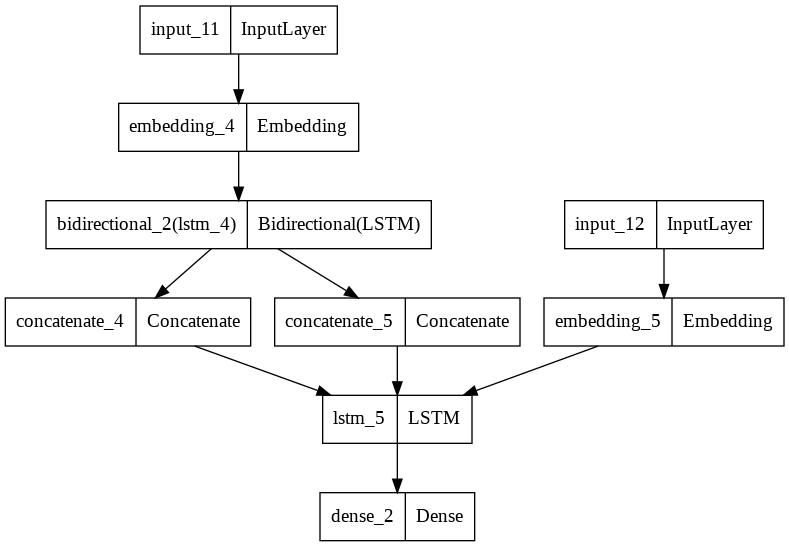

In [99]:
from tensorflow.keras.utils import plot_model
plot_model(model5)

In [88]:
model5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 512)    2932736     ['input_11[0][0]']               
                                                                                                  
 input_12 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  [(None, 512),       1574912     ['embedding_4[0][0]']            
 )                               (None, 256),                                               

In [89]:
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [90]:
y_train[:3]

array([[   2,   38, 1702, 1913,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [1302,  849,   18,   51,  370, 1876,   59,  188,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [9285, 9286,  141, 4969, 3089,  573,  837,    9,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]], dtype=int32)

**CALLBACKS**

In [91]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/", monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint, early_stopping]

In [92]:
EPOCHS = 30

PREPARING DATA FOR ENC-DEC

In [93]:
# Training
encoder_input_data = X_train
decoder_input_data = y_train[:,:-1]
decoder_target_data = y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test= y_test[:,1:]

In [94]:
history = model5.fit([encoder_input_data, decoder_input_data],decoder_target_data, 
                    epochs=EPOCHS, 
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test ),
                     callbacks= callbacks_list)

Epoch 1/30
309/309 [==============================] - ETA: 0s - loss: 0.8273 - accuracy: 0.2379INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 129s 362ms/step - loss: 0.8273 - accuracy: 0.2379 - val_loss: 0.7304 - val_accuracy: 0.2869
Epoch 2/30
309/309 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.3318INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 108s 349ms/step - loss: 0.6401 - accuracy: 0.3318 - val_loss: 0.5944 - val_accuracy: 0.3752
Epoch 3/30
309/309 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.4372INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 108s 351ms/step - loss: 0.4805 - accuracy: 0.4372 - val_loss: 0.4743 - val_accuracy: 0.4689
Epoch 4/30
309/309 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.5451INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 108s 350ms/step - loss: 0.3432 - accuracy: 0.5451 - val_loss: 0.3985 - val_accuracy: 0.5392
Epoch 5/30
309/309 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.6426INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 106s 345ms/step - loss: 0.2406 - accuracy: 0.6426 - val_loss: 0.3521 - val_accuracy: 0.5915
Epoch 6/30
309/309 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.7286INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 108s 349ms/step - loss: 0.1681 - accuracy: 0.7286 - val_loss: 0.3276 - val_accuracy: 0.6258
Epoch 7/30
309/309 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.7990INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 108s 349ms/step - loss: 0.1193 - accuracy: 0.7990 - val_loss: 0.3145 - val_accuracy: 0.6487
Epoch 8/30
309/309 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.8457INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 108s 349ms/step - loss: 0.0876 - accuracy: 0.8457 - val_loss: 0.3073 - val_accuracy: 0.6614
Epoch 9/30
309/309 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.8758INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 108s 351ms/step - loss: 0.0675 - accuracy: 0.8758 - val_loss: 0.3031 - val_accuracy: 0.6686
Epoch 10/30
309/309 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.8969INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 348ms/step - loss: 0.0539 - accuracy: 0.8969 - val_loss: 0.3030 - val_accuracy: 0.6761
Epoch 11/30
309/309 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9102INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 108s 349ms/step - loss: 0.0447 - accuracy: 0.9102 - val_loss: 0.3037 - val_accuracy: 0.6773
Epoch 12/30
309/309 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9197INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 348ms/step - loss: 0.0383 - accuracy: 0.9197 - val_loss: 0.3031 - val_accuracy: 0.6821
Epoch 13/30
309/309 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9263INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 348ms/step - loss: 0.0338 - accuracy: 0.9263 - val_loss: 0.3042 - val_accuracy: 0.6842
Epoch 14/30
309/309 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9296INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 346ms/step - loss: 0.0308 - accuracy: 0.9296 - val_loss: 0.3073 - val_accuracy: 0.6845
Epoch 15/30
309/309 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9332INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 347ms/step - loss: 0.0284 - accuracy: 0.9332 - val_loss: 0.3089 - val_accuracy: 0.6870
Epoch 16/30
309/309 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9345INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 346ms/step - loss: 0.0270 - accuracy: 0.9345 - val_loss: 0.3112 - val_accuracy: 0.6836
Epoch 17/30
309/309 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9356INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 346ms/step - loss: 0.0258 - accuracy: 0.9356 - val_loss: 0.3137 - val_accuracy: 0.6871
Epoch 18/30
309/309 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9359INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 347ms/step - loss: 0.0249 - accuracy: 0.9359 - val_loss: 0.3152 - val_accuracy: 0.6856
Epoch 19/30
309/309 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9370INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 347ms/step - loss: 0.0243 - accuracy: 0.9370 - val_loss: 0.3177 - val_accuracy: 0.6839
Epoch 20/30
309/309 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9375INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 347ms/step - loss: 0.0236 - accuracy: 0.9375 - val_loss: 0.3203 - val_accuracy: 0.6870
Epoch 21/30
309/309 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9385INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 346ms/step - loss: 0.0232 - accuracy: 0.9385 - val_loss: 0.3200 - val_accuracy: 0.6867
Epoch 22/30
309/309 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9382INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 348ms/step - loss: 0.0229 - accuracy: 0.9382 - val_loss: 0.3222 - val_accuracy: 0.6880
Epoch 23/30
309/309 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9395INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 346ms/step - loss: 0.0223 - accuracy: 0.9395 - val_loss: 0.3232 - val_accuracy: 0.6868
Epoch 24/30
309/309 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9392INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 347ms/step - loss: 0.0221 - accuracy: 0.9392 - val_loss: 0.3245 - val_accuracy: 0.6853
Epoch 25/30
309/309 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9389INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 345ms/step - loss: 0.0219 - accuracy: 0.9389 - val_loss: 0.3265 - val_accuracy: 0.6858
Epoch 26/30
309/309 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9396INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 107s 346ms/step - loss: 0.0216 - accuracy: 0.9396 - val_loss: 0.3280 - val_accuracy: 0.6872
Epoch 27/30
309/309 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9398INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


309/309 [==============================] - 106s 345ms/step - loss: 0.0214 - accuracy: 0.9398 - val_loss: 0.3286 - val_accuracy: 0.6871


In [95]:
encoder_model = Model(encoder_input, encoder_states)

decoder_state_input_h = Input(shape=(512,))
decoder_state_input_c= Input(shape=(512,))
decoder_states_input= [decoder_state_input_h, decoder_state_input_c]

dec_embd2 = decoder_embd(decoder_input)

decoder_output2,state_h2, state_c2 = decoder_lstm(dec_embd2, initial_state=decoder_states_input)
deccoder_states2= [state_h2, state_c2]

decoder_output2 = decoder_dense(decoder_output2)

decoder_model = Model(
                      [decoder_input]+decoder_states_input,
                      [decoder_output2]+ deccoder_states2)


In [96]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = mar_word_index['sos']
    
    # Sampling loop for a batch of sequences

    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index==0:
          break
        else:   
         # convert max index number to marathi word
         sampled_char = mar_index_word[sampled_token_index]
        # aapend it ti decoded sent
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence) >= 37):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    


    return decoded_sentence



In [97]:
def get_marathi_sentence(sequence):
  sentence=""
  for i in sequence:
    if ((i != 0 and i != mar_word_index['sos']) and i != mar_word_index['eos']):
      sentence = sentence + mar_index_word[i]+' '
  return sentence

def get_eng_sent(sequence):
    sentence =''
    for i in sequence:
      if(i!=0):
        sentence = sentence + eng_index_word[i]+' '
    return sentence



In [98]:
for i in range(10):
  print("English sentence:",get_eng_sent(X_test[i]))
  print("Actual Hindi Sentence:",get_marathi_sentence(y_test[i]))
  print("Translated Hindi Sentence:",get_predicted_sentence(X_test[i].reshape(1,36))[:-4])
  print("\n")

English sentence: do you know french 
Actual Hindi Sentence: sosतुम्हाला फ्रेंच येते काeos 
Translated Hindi Sentence:  फ्रेंच येते क


English sentence: she got angry 
Actual Hindi Sentence: sosत्या चिडल्याeos 
Translated Hindi Sentence:  चिडल


English sentence: what channel are you watching 
Actual Hindi Sentence: sosकोणता चॅनल बघत आहातeos 
Translated Hindi Sentence:  वेळी तू काय करतोय


English sentence: are you completely crazy 
Actual Hindi Sentence: sosतुम्ही काय पूर्णपणे वेडे आहात काeos 
Translated Hindi Sentence:  पूर्णपणे वेडे आहात क


English sentence: he looked up at the ceiling 
Actual Hindi Sentence: sosत्यांनी वर छताकडे पाहिलंeos 
Translated Hindi Sentence:  त्या वर ऐकू लागल्य


English sentence: mary is going to help us tomorrow 
Actual Hindi Sentence: sosमेरी उद्या आमची मदत करणार आहेeos 
Translated Hindi Sentence:  उद्या आपली मदत करणार आह


English sentence: that does not surprise me 
Actual Hindi Sentence: sosत्याने मला आश्चर्य होत नाहीeos 
Translated Hindi Sentence: 